## Udacity Term 1 Project 5: Vehicle Detection 

In [1]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2
import matplotlib.image as mpimg

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from imageio import imread

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### Section 1: Introduction to Histogram of Gradients
Performing and analyzing HOG features on the dataset provided by Udacity. Most of the code used was imported from the Udacity sessions with some testings for optimal results. 

In [2]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

In [3]:
car_samples = glob.glob('data/vehicles/vehicles/**/*.png')
other_samples = glob.glob('data/non-vehicles/non-vehicles/**/*.png')

In [4]:
print(len(car_samples), len(other_samples))

8792 8968


C:\Users\Aneesh\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


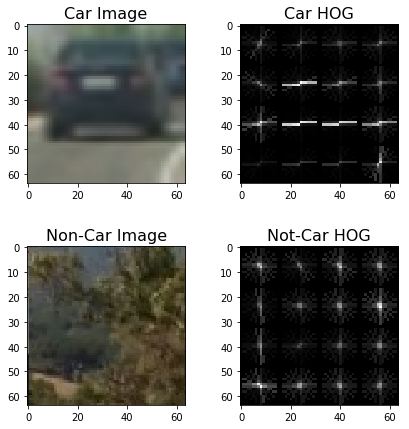

In [5]:
car_img = imread(car_samples[1])
_, car_hog_img = get_hog_features(car_img[:,:,2], 11, 16, 2, vis = True, feature_vec = True)
no_car_img = imread(other_samples[1])
_, no_car_hog_img = get_hog_features(no_car_img[:,:,2], 11, 16, 2, vis = True, feature_vec = True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_hog_img, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(no_car_img)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(no_car_hog_img, cmap='gray')
ax4.set_title('Not-Car HOG', fontsize=16)
plt.show()

In [6]:
def extract_HOG_features(imgs, cspace='YUV', orient = 9, 
                        pix_per_cell = 8, cell_per_block = 2, hog_channel = 'ALL'):
    features = []
    for file in imgs:
        image = imread(file)
        image = image.astype(np.float32)/255
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(image)      
        
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(3):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis = False, feature_vec = True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis = False, feature_vec = True)
        features.append(hog_features)
    return features

For the final set of HOG parameters, a couple of different combinations were tested limited to changes in RGB, HSV, YUV and YCbCr color space. It was necessary to opt out of the RGB color space since it gave a lot of false negative bounding boxes during video testing. Eventually, I went with the YUV color space and the (orientation, pix_per_cell, cell_per_block) combination of (11, 16, 2) since it gave the fastest (but not real time) performance. All channels were used for obtaining feature vectors - tried to mitigate the speed by converting the RGB to grayscale, using only the Y channel from YUV, but that didn't help since effective variance in the data became minimal with loss of color information. 

In [7]:
colorspace = 'YUV' 
hog_channel = 'ALL' 
orient = 11
pix_per_cell = 16
cell_per_block = 2

car_hog_features = extract_HOG_features(car_samples, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
other_hog_features = extract_HOG_features(other_samples, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

C:\Users\Aneesh\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


### Section 2: Using a classifier on HOG features

For training a classifier, I decided to go with linear SVM as compared to Naive Bayes and Decision Tree. Naive Bayes was out of question during the Udacity sessions itself, and Decision Trees were not used since they are too time consuming with respect to pruning and tend to be very biased towards the training data - which is most definitely not favored here. Since a linear SVM is used, there is no hyperparameter to be tuned and the training was performed by stacking both, the positive and negative samples for car and trying to find a nice classification boundary between the two. This led to an overall accuracy of 98.14 % on the split and a full 100% incase the split wasn't performed, hence ensuring that the classifier is good to use. 

In [8]:
features = np.vstack((car_hog_features, other_hog_features)).astype(np.float64)  
labels = np.hstack((np.ones(len(car_hog_features)), np.zeros(len(other_hog_features))))

feat_train, feat_test, label_train, label_test = train_test_split(features, labels, test_size = 0.2, random_state =  42)

In [9]:
svc = LinearSVC()
svc.fit(feat_train, label_train)
print('Accuracy of SVC = ', round(svc.score(feat_test, label_test), 4))

Accuracy of SVC =  0.9814


### Section 3: Sliding Window Search

This section describes all the components used in sliding window search stage of the overall process. The `find_cars` function is the same as discussed in the coursework with some modifications to get rid of unnecessary parameters since I didn't use them in my overall process. An example of the output from the final sliding window approach can be seen at the end. 

In [10]:
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, orient, 
              pix_per_cell, cell_per_block, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img_tosearch)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            test_prediction = svc.predict(hog_features.reshape(1, -1))
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

In [11]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [12]:
test_img = imread('./test_images/test1.jpg')

ystart = 400
ystop = 656
scale = 1.5

rectangles = find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block)

C:\Users\Aneesh\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


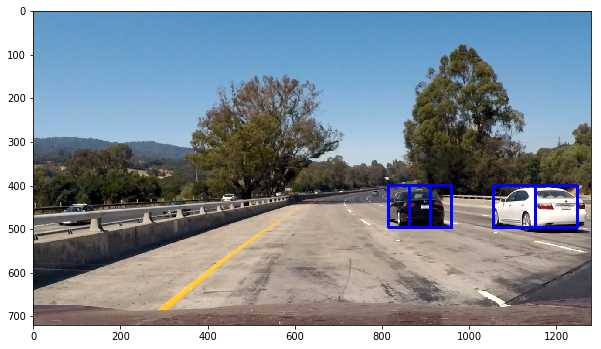

In [13]:
test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
plt.show()

The problem with sliding window is the fixed sizes and overlaps give a lot of candidates. Moreover, there is a chance (unlike this picture), where there will be false positives detected. For this reason, the next few cells are codes used for using heat-maps to remove false positives and combine output from multiple sliding windows. 

In [14]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

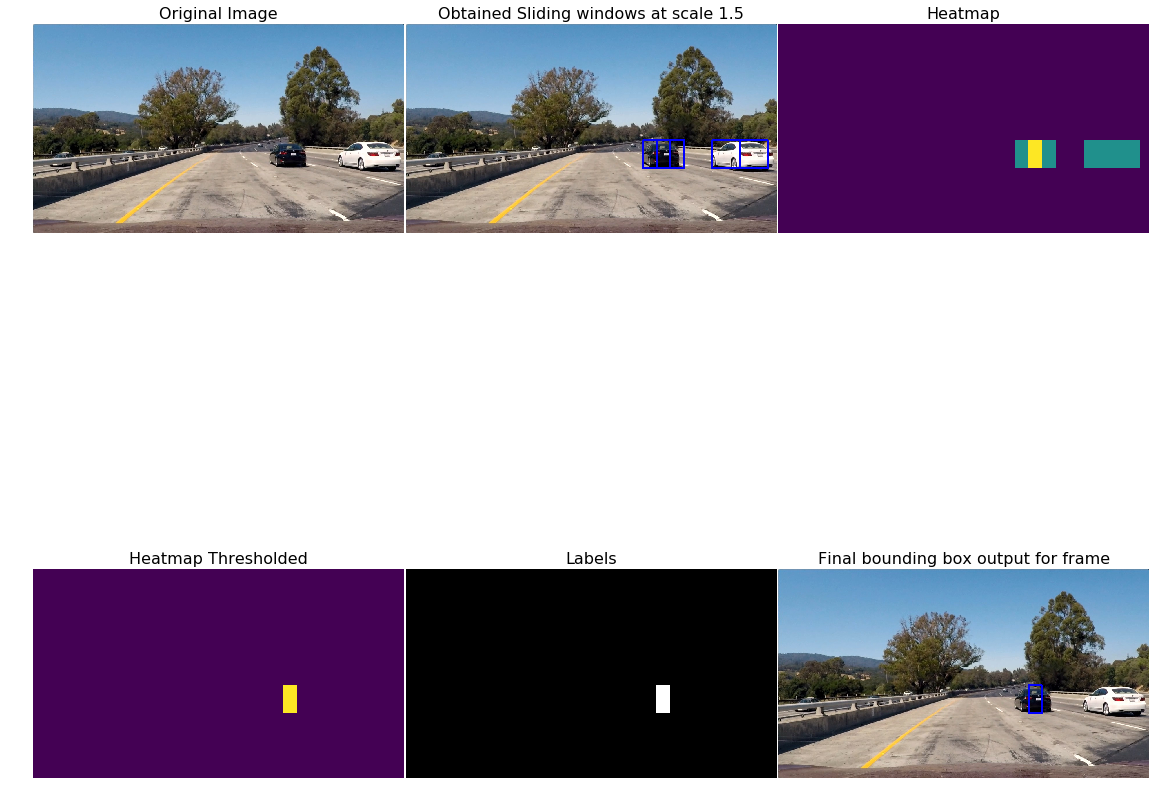

In [15]:
f, ((ax, ax0, ax1), (ax2, ax3, ax4)) = plt.subplots(2, 3, figsize=(20,20))
f.subplots_adjust(hspace = .005, wspace=.005)

plt.imshow(test_img_rects)

ax.axis('off')
ax.imshow(test_img)
ax.set_title('Original Image', fontsize=16)


ax0.axis('off')
ax0.imshow(test_img_rects)
ax0.set_title('Obtained Sliding windows at scale 1.5', fontsize=16)

heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)

ax1.axis('off')
ax1.imshow(heatmap_img)
ax1.set_title('Heatmap', fontsize=16)

heatmap_img_thresholded = apply_threshold(heatmap_img, 1)

ax2.axis('off')
ax2.imshow(heatmap_img_thresholded)
ax2.set_title('Heatmap Thresholded', fontsize=16)

labels = label(heatmap_img_thresholded)

ax3.axis('off')
ax3.imshow(labels[0], cmap='gray')
ax3.set_title('Labels', fontsize=16)

draw_img = draw_labeled_bboxes(np.copy(test_img), labels)

ax4.axis('off')
ax4.imshow(draw_img, cmap='gray')
ax4.set_title('Final bounding box output for frame', fontsize=16)

plt.show()

The above images show the process chain from obtaining multiple bounding boxes to combining them to one bounding box using heatmaps. One (and the main) problem with this approach can be seen in the images itself: threshold. Due to having significantly less bounding boxes, setting a threshold for this particular frame is difficult and hence results in not being able to detect the white car at all at the output end. To alleviate this effect, multiple scales are chosen to find the object of interest at different image resolutions and hence obtain a more concise representation. For this task, I chose 3 scales: 1.0, 1.5 and 2.0. Anything below 1.0 gave a lot of false positives and clutter, while anything above 2.0 didn't help at all. The entire pipeline is then fit into the `process_frame` function, that currently works for an image and is extended to videos (`process_frame`) in the Project.ipynb python notebook. 

In [16]:
def process_image(img):

    rectangles = []

    colorspace = 'YUV' 
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' 

    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block))

    ystart = 430
    ystop = 500
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block))

    ystart = 400
    ystop = 656
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block))

    ystart = 400
    ystop = 530
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block))

    ystart = 450
    ystop = 580
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block))

    rectangles = [item for sublist in rectangles for item in sublist] 
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

C:\Users\Aneesh\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


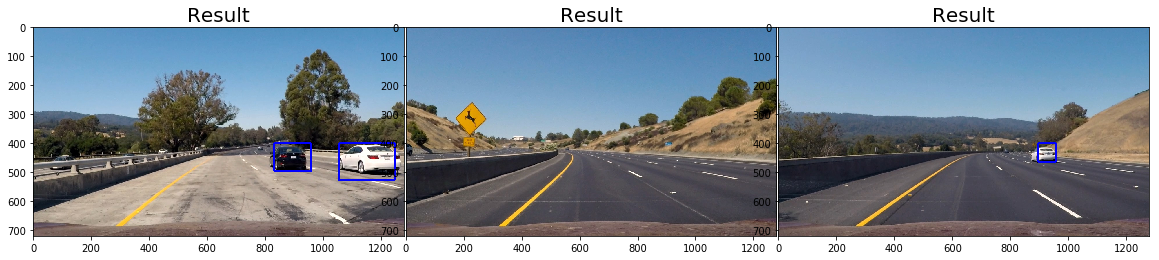

In [17]:
test_imgs = glob.glob('test_images/*.jpg')

f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(20,20))
f.subplots_adjust(hspace = .005, wspace=.005)

ax1.imshow(process_image(imread(test_imgs[0])))
ax1.set_title('Result', fontsize = 20)
ax2.imshow(process_image(imread(test_imgs[1])))
ax2.set_title('Result', fontsize = 20)
ax3.imshow(process_image(imread(test_imgs[2])))
ax3.set_title('Result', fontsize = 20)

plt.show()
